In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from utils import load_data, process_graph_data
from utils import package_mxl, adj_rw_norm
from utils import sparse_mx_to_torch_sparse_tensor
from utils import ResultRecorder

# from model import GCN, GCNBias, SGC, ResGCN, GCNII, APPNP, MLP
from load_semigcn_data import load_data_gcn
from data_loader import DataLoader

import numpy as np
import copy 
import time
from sklearn.metrics import f1_score
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from tqdm import trange
from scipy.sparse.csgraph import connected_components
import pickle
import os


In [2]:
import sys; sys.argv=['']; del sys
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import argparse
"""
Dataset arguments
"""
parser = argparse.ArgumentParser(
    description='Training GCN on Large-scale Graph Datasets')
parser.add_argument('--dataset', type=str, default='cora',
                    help='Dataset name: pubmed/flickr/reddit/ppi-large')
parser.add_argument('--method', type=str, default='GCN/ResGCN/GCNII', # SGC/GCN/GCNBias/ResGCN/GCNII/APPNP
                    help='Algorithms: seperate using slash')
parser.add_argument('--nhid', type=int, default=64,
                    help='Hidden state dimension')
parser.add_argument('--epoch_num', type=int, default=2000,
                    help='Number of Epoch')
parser.add_argument('--batch_size', type=int, default=99999999,
                    help='size of output node in a batch')
parser.add_argument('--n_layers', type=int, default=6,
                    help='Number of GCN layers')
parser.add_argument('--dropout', type=float, default=0,
                    help='Dropout rate')
parser.add_argument('--cuda', type=int, default=0,
                    help='Avaiable GPU ID')
args = parser.parse_args()
print(args)

method = args.method.split('/')

"""
Prepare devices
"""
if args.cuda != -1:
    device = torch.device("cuda:" + str(args.cuda))
else:
    device = torch.device("cpu")
    
if args.dataset not in ['cora', 'citeseer', 'pubmed']:
    temp_data = load_data(args.dataset) 
else:
    temp_data = load_data_gcn(args.dataset)

adj_full, adj_train, feat_data, labels, role = process_graph_data(*temp_data)

train_nodes = np.array(role['tr'])
valid_nodes = np.array(role['va'])
test_nodes = np.array(role['te'])

data_loader = DataLoader(adj_full, train_nodes, valid_nodes, test_nodes, device)

Namespace(batch_size=99999999, cuda=0, dataset='cora', dropout=0, epoch_num=2000, method='GCN/ResGCN/GCNII', n_layers=6, nhid=64)


In [3]:
# def weight_constaint(model):
#     for p in model.parameters():
#         if p.data.norm(2) > 20:
#             p.data = p.data / p.data.norm(2)

In [4]:
"""
Setup datasets and models for training (multi-class use sigmoid+binary_cross_entropy, use softmax+nll_loss otherwise)
"""

if args.dataset in ['flickr', 'reddit', 'cora', 'citeseer', 'pubmed']:
    feat_data_th = torch.FloatTensor(feat_data)
    labels_th = torch.LongTensor(labels.argmax(1))
    num_classes = labels_th.max().item()+1
    criterion = nn.CrossEntropyLoss()
    multi_class=False
elif args.dataset in ['ppi', 'ppi-large', 'amazon', 'yelp']:
    feat_data_th = torch.FloatTensor(feat_data)
    labels_th = torch.FloatTensor(labels)
    num_classes = labels_th.shape[1]
    criterion = nn.BCEWithLogitsLoss()
    multi_class=True

feat_data_th = feat_data_th.to(device)
labels_th = labels_th.to(device)

def sgd_step(net, optimizer, feat_data, labels, train_data, device):
    """
    Function to updated weights with a SGD backpropagation
    args : net, optimizer, train_loader, test_loader, loss function, number of inner epochs, args
    return : train_loss, test_loss, grad_norm_lb
    """
    net.train()
    epoch_loss = []
    epoch_acc = []
    
    # Run over the train_loader
    mini_batches, adj = train_data
    for mini_batch in mini_batches:

        # compute current stochastic gradient
        optimizer.zero_grad()
        output = net(feat_data, adj)
        
        loss = net.criterion(output[mini_batch], labels[mini_batch])
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(net.parameters(), 0.4)
        
        optimizer.step()
        epoch_loss.append(loss.item())
        
        if multi_class:
            output[output > 0.5] = 1
            output[output <= 0.5] = 0
        else:
            output = output.argmax(dim=1)

        acc = f1_score(output[mini_batch].detach().cpu(), 
                       labels[mini_batch].detach().cpu(), average="micro")
        epoch_acc.append(acc)

    return epoch_loss, epoch_acc

@torch.no_grad()
def inference(eval_model, feat_data, labels, test_data, device):
    eval_model = eval_model.to(device)
    mini_batch, adj = test_data    
    output = eval_model(feat_data, adj)
    loss = eval_model.criterion(output[mini_batch], labels[mini_batch]).item()
    
    if multi_class:
        output[output > 0.5] = 1
        output[output <= 0.5] = 0
    else:
        output = output.argmax(dim=1)
        
    acc = f1_score(output[mini_batch].detach().cpu(), 
                   labels[mini_batch].detach().cpu(), average="micro")
    return loss, acc

In [5]:
from collections import OrderedDict
def copy_model(model):
    state_dict = {k:v.to('cpu') for k, v in model.named_parameters()}
    state_dict = OrderedDict(state_dict)
    return state_dict
def copy_grad(model):
    state_dict = {k:v.grad.to('cpu') for k, v in model.named_parameters()}
    state_dict = OrderedDict(state_dict)
    return state_dict

In [6]:
"""
Train without sampling
"""

def train_model(model, data_loader, note):
    train_model = copy.deepcopy(model).to(device)
    
    results = ResultRecorder(note=note)
    
    optimizer = optim.Adam(train_model.parameters())

    tbar = trange(args.epoch_num, desc='Training Epochs')
    for epoch in tbar:
        # fetch train data 
        
        sample_time_st = time.perf_counter()
        train_data = data_loader.get_mini_batches(batch_size=args.batch_size)
        sample_time = time.perf_counter() - sample_time_st
        
        compute_time_st = time.perf_counter()
        train_loss, train_acc = sgd_step(train_model, optimizer, feat_data_th, labels_th, train_data, device)
        compute_time = time.perf_counter() - compute_time_st
        
        if epoch % 20 == 0:
            results.grad_norms += [copy_grad(train_model)]
            results.state_dicts += [copy_model(train_model)]
        
        epoch_train_loss = np.mean(train_loss)
        epoch_train_acc = np.mean(train_acc)

        valid_data = data_loader.get_valid_batch()
        epoch_valid_loss, epoch_valid_acc = inference(train_model, feat_data_th, labels_th, valid_data, device)
        tbar.set_postfix(train_loss=epoch_train_loss,
                         train_acc=epoch_train_acc,
                         valid_loss=epoch_valid_loss,
                         valid_score=epoch_valid_acc)

        results.update(epoch_train_loss, 
                       epoch_train_acc,
                       epoch_valid_loss, 
                       epoch_valid_acc, 
                       train_model, sample_time=sample_time, compute_time=compute_time)
        


    test_data = data_loader.get_test_batch()
    epoch_test_loss, epoch_test_acc = inference(results.best_model, feat_data_th, labels_th, test_data, device)
    results.test_loss = epoch_test_loss
    results.test_acc = epoch_test_acc
    
    print('Test_loss: %.4f | test_acc: %.4f' % (epoch_test_loss, epoch_test_acc))
    
    print('Average sampling time %.5fs, average computing time %.5fs'%
          (np.mean(results.sample_time), np.mean(results.compute_time)))
    
    return results

In [7]:
class GCN(nn.Module):
    def __init__(self, n_feat, n_hid, n_classes, n_layers, dropout, criterion):
        from layers import GraphConv
        super(GCN, self).__init__()
        self.n_layers = n_layers
        self.n_hid = n_hid
        
        self.gcs = nn.ModuleList()
        for _ in range(n_layers):
            self.gcs.append(GraphConv(n_hid,  n_hid))
        self.linear_in = nn.Linear(n_feat, n_hid)
        self.linear_out = nn.Linear(n_hid, n_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.criterion = criterion

    def forward(self, x, adj):
        x = self.linear_in(x)
        for ell in range(len(self.gcs)):
            x = self.gcs[ell](x, adj)
            x = self.relu(x)
            x = self.dropout(x)
        x = self.linear_out(x)
        return x
    
class ResGCN(nn.Module):
    def __init__(self, n_feat, n_hid, n_classes, n_layers, dropout, criterion):
        from layers import GraphConv
        super(ResGCN, self).__init__()
        self.n_layers = n_layers
        self.n_hid = n_hid
        
        self.gcs = nn.ModuleList()
        for _ in range(n_layers):
            self.gcs.append(GraphConv(n_hid,  n_hid))
        self.linear_in = nn.Linear(n_feat, n_hid)
        self.linear_out = nn.Linear(n_hid, n_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.criterion = criterion

    def forward(self, x, adj):
        x = self.linear_in(x)
        for ell in range(len(self.gcs)):
            x_res = x.clone()
            x = self.gcs[ell](x, adj)
            x = self.relu(x)
            x = self.dropout(x) + x_res
        x = self.linear_out(x)
        return x
    
class GCNII(nn.Module):
    def __init__(self, n_feat, n_hid, n_classes, n_layers, dropout, criterion):
        from layers import GCNIILayer
        super(GCNII, self).__init__()
        self.n_layers = n_layers
        self.n_hid = n_hid
        
        self.gcs = nn.ModuleList()
        for _ in range(n_layers):
            self.gcs.append(GCNIILayer(n_hid,  n_hid))
        self.linear_in = nn.Linear(n_feat, n_hid)
        self.linear_out = nn.Linear(n_hid, n_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.criterion = criterion

    def get_alpha_beta(self, ell):
        alpha = 0.8
        beta = 0.8
        return alpha, beta
    
    def forward(self, x, adj):
        x = self.linear_in(x)
        x_0 = x.clone()
        for ell in range(len(self.gcs)):
            alpha, beta = self.get_alpha_beta(ell)
            x = self.gcs[ell](x, adj, x_0, alpha, beta)
            x = self.relu(x)
            x = self.dropout(x)
        x = self.linear_out(x)
        return x

In [8]:

results_list = []
for repeat in range(5):
    if 'GCN' in method:
        model = GCN(n_feat=feat_data.shape[1], 
                    n_hid=args.nhid, 
                    n_classes=num_classes, 
                    n_layers=args.n_layers, 
                    dropout=args.dropout, 
                    criterion=criterion)

        results = train_model(model, data_loader, note="GCN (L=%d)"%args.n_layers)
        results_list.append(results)

    if 'ResGCN' in method:
        model = ResGCN(n_feat=feat_data.shape[1], 
                    n_hid=args.nhid, 
                    n_classes=num_classes, 
                    n_layers=args.n_layers, 
                    dropout=args.dropout, 
                    criterion=criterion)

        results = train_model(model, data_loader, note="ResGCN (L=%d)"%args.n_layers)
        results_list.append(results)
    if 'GCNII' in method:
        model = GCNII(n_feat=feat_data.shape[1], 
                    n_hid=args.nhid, 
                    n_classes=num_classes, 
                    n_layers=args.n_layers, 
                    dropout=args.dropout, 
                    criterion=criterion)

        results = train_model(model, data_loader, note="GCNII (L=%d)"%args.n_layers)
        results_list.append(results)

Training Epochs:   0%|          | 10/2000 [00:00<00:20, 97.28it/s, train_acc=0.82, train_loss=0.851, valid_loss=0.897, valid_score=0.784] 

Test_loss: 0.7841 | test_acc: 0.8220
Average sampling time 0.00003s, average computing time 0.00616s


Training Epochs:   0%|          | 10/2000 [00:00<00:21, 92.66it/s, train_acc=0.293, train_loss=1.82, valid_loss=1.82, valid_score=0.294]

Test_loss: 0.4820 | test_acc: 0.8610
Average sampling time 0.00004s, average computing time 0.00618s


Training Epochs:   1%|          | 11/2000 [00:00<00:18, 106.67it/s, train_acc=0.291, train_loss=1.79, valid_loss=1.81, valid_score=0.294]

Test_loss: 0.7459 | test_acc: 0.8290
Average sampling time 0.00003s, average computing time 0.00665s


Training Epochs:   0%|          | 10/2000 [00:00<00:19, 99.82it/s, train_acc=0.812, train_loss=0.825, valid_loss=0.892, valid_score=0.762]

Test_loss: 1.7417 | test_acc: 0.8010
Average sampling time 0.00003s, average computing time 0.00593s


Training Epochs:   0%|          | 10/2000 [00:00<00:21, 90.50it/s, train_acc=0.392, train_loss=1.89, valid_loss=1.89, valid_score=0.398]

Test_loss: 0.5819 | test_acc: 0.8590
Average sampling time 0.00003s, average computing time 0.00635s


Training Epochs:   1%|          | 11/2000 [00:00<00:18, 108.27it/s, train_acc=0.291, train_loss=1.79, valid_loss=1.78, valid_score=0.294]

Test_loss: 0.6357 | test_acc: 0.8310
Average sampling time 0.00003s, average computing time 0.00668s


Training Epochs:   0%|          | 10/2000 [00:00<00:20, 96.21it/s, train_acc=0.813, train_loss=0.789, valid_loss=0.838, valid_score=0.766]

Test_loss: 1.3756 | test_acc: 0.8120
Average sampling time 0.00003s, average computing time 0.00600s


Training Epochs:   0%|          | 10/2000 [00:00<00:20, 95.09it/s, train_acc=0.468, train_loss=1.84, valid_loss=1.85, valid_score=0.408]

Test_loss: 0.4992 | test_acc: 0.8480
Average sampling time 0.00003s, average computing time 0.00621s


Training Epochs:   1%|          | 11/2000 [00:00<00:19, 103.16it/s, train_acc=0.291, train_loss=1.86, valid_loss=1.85, valid_score=0.294]

Test_loss: 1.2180 | test_acc: 0.8420
Average sampling time 0.00003s, average computing time 0.00683s


Training Epochs:   1%|          | 11/2000 [00:00<00:20, 99.35it/s, train_acc=0.822, train_loss=0.909, valid_loss=0.941, valid_score=0.766]

Test_loss: 0.8545 | test_acc: 0.8280
Average sampling time 0.00003s, average computing time 0.00612s


Training Epochs:   0%|          | 10/2000 [00:00<00:21, 90.80it/s, train_acc=0.296, train_loss=1.86, valid_loss=1.85, valid_score=0.294]

Test_loss: 0.4783 | test_acc: 0.8640
Average sampling time 0.00003s, average computing time 0.00633s


Training Epochs:   1%|          | 11/2000 [00:00<00:18, 106.29it/s, train_acc=0.164, train_loss=1.89, valid_loss=1.89, valid_score=0.16] 

Test_loss: 0.6963 | test_acc: 0.8450
Average sampling time 0.00003s, average computing time 0.00680s


Training Epochs:   0%|          | 10/2000 [00:00<00:20, 98.49it/s, train_acc=0.792, train_loss=0.786, valid_loss=0.837, valid_score=0.752]

Test_loss: 1.6598 | test_acc: 0.8120
Average sampling time 0.00003s, average computing time 0.00605s


Training Epochs:   0%|          | 10/2000 [00:00<00:20, 94.82it/s, train_acc=0.346, train_loss=1.86, valid_loss=1.85, valid_score=0.32] 

Test_loss: 0.5717 | test_acc: 0.8560
Average sampling time 0.00003s, average computing time 0.00623s


Training Epochs: 100%|██████████| 2000/2000 [00:20<00:00, 98.26it/s, train_acc=1, train_loss=2.53e-5, valid_loss=2.98, valid_score=0.838]   

Test_loss: 0.7793 | test_acc: 0.8290
Average sampling time 0.00003s, average computing time 0.00666s


In [9]:


def get_weight_grad_norms(state_dicts_w, state_dicts_g, loss_record):
    grad_div_weight = []
    loss_div_weight = []
    for i in range(1,len(state_dicts_w)):
        prev_model = state_dicts_w[i-1]
        curt_model = state_dicts_w[i]
        
        pred_grads = state_dicts_g[i-1]
        curt_grads = state_dicts_g[i]

        weight_norms_sum = 0
        for (n1, p1), (n2, p2) in zip(prev_model.items(), curt_model.items()):
            weight_norms_sum += (p1-p2).norm(2).pow(2).item()

        grad_norms_sum = 0
        for (n1, p1), (n2, p2) in zip(pred_grads.items(), curt_grads.items()):
            grad_norms_sum += (p1-p2).norm(2).pow(2).item()
            
        grad_div_weight.append(grad_norms_sum/weight_norms_sum)
        
        prev_loss = loss_record[i-1]
        curt_loss = loss_record[i]
        
        loss_div_weight.append(np.abs(curt_loss-prev_loss)/weight_norms_sum)
    return grad_div_weight, loss_div_weight



def get_grad_norms(state_dicts):
    grad_norms_list = []
    for i in range(len(state_dicts)):
        curt_model = state_dicts[i]

        grad_norms = {}
        grad_norms_sum = 0
        cnt = 0
        for (n1, p1) in curt_model.items():
            if 'weight' in n1:
                cnt += 1
                grad_norms[n1] = p1.norm(2).item()
                grad_norms_sum += p1.norm(2).pow(2).item()
        grad_norms['all_params'] = np.sqrt(grad_norms_sum/cnt)
        grad_norms_list.append(grad_norms)
    return grad_norms_list

def get_weight_norms(state_dicts):
    weight_norms_list = []
    for i in range(len(state_dicts)):
        curt_model = state_dicts[i]

        weight_norms = {}
        weight_norms_sum = 0
        cnt = 0
        for (n1, p1)in curt_model.items():
            if 'weight' in n1:
                cnt += 1
                # weight_norms[n1] = p1.norm(2).item()
                # weight_norms_sum += p1.norm(2).pow(2).item()
                U, S, V = torch.svd(p1.data, compute_uv=False)
                weight_norms[n1] = S.max().item()
                weight_norms_sum += S.max()
        # weight_norms['all_params'] = np.sqrt(weight_norms_sum/cnt)
        weight_norms['all_params'] = weight_norms_sum/cnt
        weight_norms_list.append(weight_norms)
    return weight_norms_list

In [10]:
cnt = 0
# for n, p in results_list[0].state_dicts[100].items():
#     print(n)
#     if 'weight' in n:
#         cnt += 1
#         U, S, V = torch.svd(p.data, compute_uv=False)
#         print(S.max().item())
get_weight_norms(results_list[0].state_dicts[:10])

[{'gcs.0.linear.weight': 1.125072956085205,
  'gcs.1.linear.weight': 1.1211296319961548,
  'gcs.2.linear.weight': 1.11721670627594,
  'gcs.3.linear.weight': 1.1188472509384155,
  'gcs.4.linear.weight': 1.1147093772888184,
  'gcs.5.linear.weight': 1.1524395942687988,
  'linear_in.weight': 0.6910081505775452,
  'linear_out.weight': 0.6700592637062073,
  'all_params': tensor(1.0138)},
 {'gcs.0.linear.weight': 1.2886104583740234,
  'gcs.1.linear.weight': 1.154836893081665,
  'gcs.2.linear.weight': 1.1917667388916016,
  'gcs.3.linear.weight': 1.1601731777191162,
  'gcs.4.linear.weight': 1.156502604484558,
  'gcs.5.linear.weight': 1.1781680583953857,
  'linear_in.weight': 3.7434494495391846,
  'linear_out.weight': 0.7111773490905762,
  'all_params': tensor(1.4481)},
 {'gcs.0.linear.weight': 1.958315372467041,
  'gcs.1.linear.weight': 1.6484711170196533,
  'gcs.2.linear.weight': 1.54541015625,
  'gcs.3.linear.weight': 1.4762190580368042,
  'gcs.4.linear.weight': 1.4404553174972534,
  'gcs.5.l

In [11]:
# fig, axs = plt.subplots()

# for results in results_list:
#     grad_div_weight, loss_div_weight = get_weight_grad_norms(results.state_dicts, results.grad_norms, results.train_loss_record)
#     y_vals = grad_div_weight
#     print(results.note, y_vals[0])
#     x_vals = np.arange(len(y_vals))
#     axs.plot(x_vals, y_vals, label=results.note)
    
# plt.title('Smoothness / Iters')
# axs.set_xlabel('Iters')
# axs.set_ylabel('Gradient norm / weight norm')

# # plt.ylim(0,0.2)
# axs.grid(True)
# fig.tight_layout()
# plt.legend()

In [12]:
# fig, axs = plt.subplots()

# for results in results_list:
#     grad_div_weight, loss_div_weight = get_weight_grad_norms(results.state_dicts, results.grad_norms, results.train_loss_record)
#     y_vals = loss_div_weight
#     print(results.note, y_vals[0])
#     x_vals = np.arange(len(y_vals))
#     axs.plot(x_vals, y_vals, label=results.note)
    
# plt.title('Lipschitz / Iters')
# axs.set_xlabel('Iters')
# axs.set_ylabel('Loss diff / weight norm')

# # plt.ylim(0,0.2)
# axs.grid(True)
# fig.tight_layout()
# plt.legend()

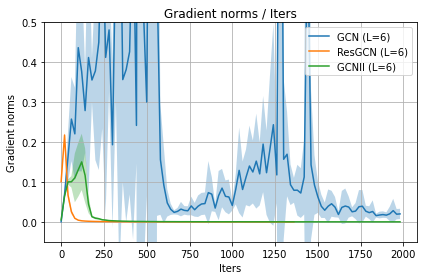

In [22]:
fig, axs = plt.subplots()

# for results in results_list:
#     print(results.note)
#     grad_norms_list = get_grad_norms(results.grad_norms)
#     y_vals = [grad_norm['all_params'] for grad_norm in grad_norms_list]
#     x_vals = np.arange(len(y_vals))
#     axs.plot(x_vals, y_vals, label=results.note)

for algorithm in ['GCN', 'ResGCN', 'GCNII']:
    train_acc = []
    y_vals = []
    for result in results_list:
        if result.note.split()[0] == algorithm:
            train_acc.append(np.array(result.train_acc_record))
            grad_norms_list = get_grad_norms(result.grad_norms)
            y_vals_ = [grad_norm['all_params'] for grad_norm in grad_norms_list]
            y_vals.append(np.array(y_vals_))

    train_acc = np.mean(train_acc, axis=0)
    x_stop = np.argmax(train_acc)

    y_val_mean = np.mean(y_vals, axis=0)[:x_stop]
    y_val_std = np.std(y_vals, axis=0)[:x_stop]
    x_vals = np.arange(len(y_val_mean))

    axs.plot(x_vals*20, y_val_mean, label='%s (L=%d)'%(algorithm, args.n_layers))
    axs.fill_between(x_vals*20, y_val_mean-y_val_std, y_val_mean+y_val_std ,alpha=0.3)
    
plt.title('Gradient norms / Iters')
axs.set_xlabel('Iters')
axs.set_ylabel('Gradient norms')

plt.ylim(-.05,0.5)
axs.grid(True)
fig.tight_layout()
plt.legend()

plt.savefig('gradient norm.pdf')

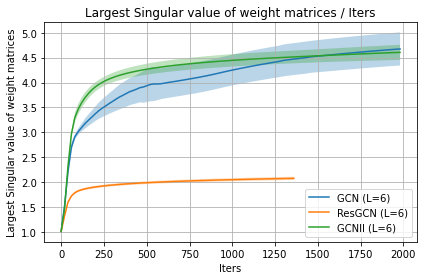

In [14]:
fig, axs = plt.subplots()

# for results in results_list:
#     print(results.note)
#     grad_norms_list = get_grad_norms(results.grad_norms)
#     y_vals = [grad_norm['all_params'] for grad_norm in grad_norms_list]
#     x_vals = np.arange(len(y_vals))
#     axs.plot(x_vals, y_vals, label=results.note)

for algorithm in ['GCN', 'ResGCN', 'GCNII']:
    train_acc = []
    y_vals = []
    for result in results_list:
        if result.note.split()[0] == algorithm:
            train_acc.append(np.array(result.train_acc_record))
            grad_norms_list = get_weight_norms(result.state_dicts)
            y_vals_ = [grad_norm['all_params'] for grad_norm in grad_norms_list]
            y_vals.append(np.array(y_vals_))

    train_acc = np.mean(train_acc, axis=0)
    x_stop = np.argmax(train_acc)

    y_val_mean = np.mean(y_vals, axis=0)[:x_stop]
    y_val_std = np.std(y_vals, axis=0)[:x_stop]
    x_vals = np.arange(len(y_val_mean))

    axs.plot(x_vals*20, y_val_mean, label='%s (L=%d)'%(algorithm, args.n_layers))
    axs.fill_between(x_vals*20, y_val_mean-y_val_std, y_val_mean+y_val_std ,alpha=0.3)
    
plt.title('Largest Singular value of weight matrices / Iters')
axs.set_xlabel('Iters')
axs.set_ylabel('Largest Singular value of weight matrices')

# plt.ylim(0,1)
axs.grid(True)
fig.tight_layout()
plt.legend()

plt.savefig('singular_weight.pdf')

In [15]:
# fig, axs = plt.subplots()

# for results in results_list:
#     print(results.note)
#     grad_norms_list = get_weight_norms(results.state_dicts)
#     y_vals = [grad_norm['all_params'] for grad_norm in grad_norms_list]
#     x_vals = np.arange(len(y_vals))
#     axs.plot(x_vals, y_vals, label=results.note)
    
# plt.title('Weight norms / Iters')
# axs.set_xlabel('Iters')
# axs.set_ylabel('Gradient norms')

# # plt.ylim(0,1)
# axs.grid(True)
# fig.tight_layout()
# plt.legend()

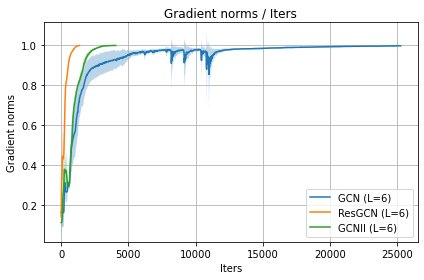

In [16]:
fig, axs = plt.subplots()

# for results in results_list:
#     print(results.note)
#     grad_norms_list = get_grad_norms(results.grad_norms)
#     y_vals = [grad_norm['all_params'] for grad_norm in grad_norms_list]
#     x_vals = np.arange(len(y_vals))
#     axs.plot(x_vals, y_vals, label=results.note)

for algorithm in ['GCN', 'ResGCN', 'GCNII']:
    train_acc = []
    y_vals = []
    for result in results_list:
        if result.note.split()[0] == algorithm:
            train_acc.append(np.array(result.train_acc_record))

    x_stop = np.argmax(np.mean(train_acc, axis=0))

    y_val_mean = np.mean(train_acc, axis=0)[:x_stop]
    y_val_std = np.std(train_acc, axis=0)[:x_stop]
    x_vals = np.arange(len(y_val_mean))

    axs.plot(x_vals*20, y_val_mean, label='%s (L=%d)'%(algorithm, args.n_layers))
    axs.fill_between(x_vals*20, y_val_mean-y_val_std, y_val_mean+y_val_std ,alpha=0.3)
    
plt.title('Gradient norms / Iters')
axs.set_xlabel('Iters')
axs.set_ylabel('Gradient norms')

# plt.ylim(-.1,0.8)
axs.grid(True)
fig.tight_layout()
plt.legend()

plt.savefig('gradient norm.pdf')

In [17]:
# fig, axs = plt.subplots()

# # for result in results_list:
# #     print(result.note)
        
# #     y_vals = result.acc_record
# #     x_vals = np.arange(len(y_vals))
# #     axs.plot(x_vals, y_vals, label=result.note)

# for algorithm in ['GCN', 'ResGCN', 'GCNII']:
#     train_acc = []
#     y_vals = []
#     for result in results_list:
#         if result.note.split()[0] == algorithm:
#             train_acc.append(np.array(result.train_acc_record))
#             grad_norms_list = get_grad_norms(result.grad_norms)
#             y_vals_ = [grad_norm['all_params'] for grad_norm in grad_norms_list]
#             y_vals.append(np.array(y_vals_))

#     train_acc = np.mean(train_acc, axis=0)
#     x_stop = np.argmax(train_acc)

#     y_val_mean = np.mean(y_vals, axis=0)[:x_stop]
#     y_val_std = np.mean(y_vals, axis=0)[:x_stop]
#     x_vals = np.arange(len(y_val_mean))

#     axs.plot(x_vals, y_val_mean, label='%s (L=%d)'%(algorithm, args.n_layers))
#     axs.fill_between(x_vals, y_val_mean-y_val_std, y_val_mean+y_val_std ,alpha=0.3)
    
    
# plt.title('Valid F1-score / Epoch')
# axs.set_xlabel('Epoch')
# axs.set_ylabel('F1-score')
# axs.grid(True)

# fig.tight_layout()
# plt.legend()


In [18]:
np.sort([2,4,1])

array([1, 2, 4])

In [ ]:
import torch
a = torch.nn.Linear(3,4)